# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

## Имортируем все необходимые библиотеки и устанавливаем параметры для дальнейшей работы


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
frame = pd.read_csv('data.csv',sep = '\t')
pd.set_option("display.max_columns", 35)
pd.set_option("display.precision", 3)


Введем определения,которыми будем пользоваться в течение работы:  
1. Кварти́ра-сту́дия — тип квартиры, основным отличием которого является отсутствие внутренних перегородок между кухней и жилыми комнатами или комнатой.


### Шаг 1. Откройте файл с данными и изучите общую информацию. 

In [2]:
frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null object
rooms                   23699 non-null int64
ceiling_height          14504 non-null float64
floors_total            23613 non-null float64
living_area             21796 non-null float64
floor                   23699 non-null int64
is_apartment            2775 non-null object
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 12180 non-null float64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_around300

Всего в фрейме 23699 строк, заметим что есть строки с пропусками. Столбцы с пропусками: ceiling_height, living_area,floors_total,is_apartment,kitchen_area ,balcony,locality_name,airports_nearest ,cityCenters_nearest,
parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition.

Всего 14 столбцов с пропусками

Проверим названия столбцов на их корректность

In [3]:
frame.columns

Index(['total_images', 'last_price', 'total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
       'is_apartment', 'studio', 'open_plan', 'kitchen_area', 'balcony',
       'locality_name', 'airports_nearest', 'cityCenters_nearest',
       'parks_around3000', 'parks_nearest', 'ponds_around3000',
       'ponds_nearest', 'days_exposition'],
      dtype='object')

Все впорядке, теперь посмотрим описание значений каждого столбца

In [4]:
frame.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,23699.000,2.370e+04,23699.000,23699.000,14504.000,23613.000,21796.000,23699.000,21421.000,12180.000,18157.000,18180.000,18181.000,8079.000,18181.000,9110.000,20518.000
mean,9.858,6.542e+06,60.349,2.071,2.771,10.674,34.458,5.892,10.570,1.150,28793.672,14191.278,0.611,490.805,0.770,517.981,180.889
std,5.683,1.089e+07,35.654,1.078,1.261,6.597,22.030,4.885,5.905,1.071,12630.881,8608.386,0.802,342.318,0.938,277.721,219.728
min,0.000,1.219e+04,12.000,0.000,1.000,1.000,2.000,1.000,1.300,0.000,0.000,181.000,0.000,1.000,0.000,13.000,1.000
25%,6.000,3.400e+06,40.000,1.000,2.520,5.000,18.600,2.000,7.000,0.000,18585.000,9238.000,0.000,288.000,0.000,294.000,45.000
50%,9.000,4.650e+06,52.000,2.000,2.650,9.000,30.000,4.000,9.100,1.000,26726.000,13098.500,0.000,455.000,1.000,502.000,95.000
75%,14.000,6.800e+06,69.900,3.000,2.800,16.000,42.300,8.000,12.000,2.000,37273.000,16293.000,1.000,612.000,1.000,729.000,232.000
max,50.000,7.630e+08,900.000,19.000,100.000,60.000,409.700,33.000,112.000,5.000,84869.000,65968.000,3.000,3190.000,3.000,1344.000,1580.000


Заметим. что есть артефакты в следующих столбцах: rooms(min),ceiling_height(min),living_area(min),kitchen_area(min),airports_nearest

### Вывод

Изначально данные имеют большое количество артефактов и пропущнных значений

### Шаг 2. Предобработка данных

Для однокомнатной квартиры установлены особые требования по количеству квадратных метров в жилой комнате – 14. Тогда как в двух- и более комнатных жилищах планка поднята выше – до 16 для общей комнаты.

Для кухни установлены минимальные значения в 8 квадратных метров

минимальное расстояние от напольного покрытия до потолка в жилой комнате и кухне должно быть не менее двух с половиной метров, тогда как антресоли, коридоры и другие нежилые помещения должны иметь высоту не менее 210 сантиметров.

Обработаем артефокты в living_area

In [5]:
def min_living_area(row):
    if row["rooms"] <= 1 and row['living_area'] < 14:
        row['total_area'] += 14 - row['living_area']
        row['living_area']  = 14
    elif row["rooms"] > 1 and row['living_area'] < 16:
        row['total_area'] += 16 - row['living_area']
        row['living_area']  = 16
    return row
        

In [6]:
frame = frame.apply(min_living_area, axis = 1)

Теперь займемся студиями

In [7]:
frame.query('rooms == 1 and studio != True')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
1,7,3.350e+06,40.40,2018-12-04T00:00:00,1,NaN,11.0,18.60,1,NaN,False,False,11.00,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
5,10,2.890e+06,30.40,2018-09-10T00:00:00,1,NaN,12.0,14.40,5,NaN,False,False,9.10,NaN,городской посёлок Янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55.0
6,6,3.700e+06,40.70,2017-11-02T00:00:00,1,NaN,26.0,14.00,6,NaN,False,False,14.40,1.0,посёлок Парголово,52996.0,19143.0,0.0,NaN,0.0,NaN,155.0
8,20,2.900e+06,33.16,2018-05-23T00:00:00,1,NaN,27.0,15.43,26,NaN,False,False,8.81,NaN,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,189.0
10,5,5.050e+06,39.60,2017-11-16T00:00:00,1,2.67,12.0,20.30,3,NaN,False,False,8.50,NaN,Санкт-Петербург,38357.0,13878.0,1.0,310.0,2.0,553.0,137.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23686,8,3.300e+06,31.00,2017-04-29T00:00:00,1,2.55,9.0,18.00,6,NaN,False,False,6.50,0.0,Санкт-Петербург,11751.0,11602.0,1.0,140.0,1.0,317.0,193.0
23687,6,3.200e+06,39.00,2017-12-16T00:00:00,1,NaN,9.0,20.00,6,NaN,False,False,11.00,2.0,Санкт-Петербург,40837.0,16704.0,0.0,NaN,0.0,NaN,38.0
23689,13,3.550e+06,35.30,2018-02-28T00:00:00,1,2.86,15.0,16.30,4,NaN,False,False,9.10,2.0,Санкт-Петербург,17284.0,16081.0,1.0,353.0,2.0,652.0,29.0
23692,2,1.350e+06,30.00,2017-07-07T00:00:00,1,NaN,5.0,17.50,4,NaN,False,False,6.00,NaN,Тихвин,NaN,NaN,NaN,NaN,NaN,NaN,413.0


In [8]:
result = (len(frame.query('rooms == 0')) == len(frame.query('rooms == 0 and studio == True')))

In [9]:
print("Проверим, совпадает ли количество 0-комнатных квартир с количеством студий. Результат:", result)

Проверим, совпадает ли количество 0-комнатных квартир с количеством студий. Результат: False


Как можно увидеть, ответ отрицательный, следовательно напрашивается два метода решения этой проблемы:
1. Увеличить количество комнат на 1
1. Изменить флаг студии из положения False в True
1. Если провести дополнительное исследование, то можно заметить что у студий отсутсвует площадь кухни, так как по опрелению студии при ее планировки кухню не выделяют как отдельное помещение. Значит ниболее верный вариант, будет изменить флаг столбца studio только у тех квартир, где 0 комнат и отсутвуют данные по площади кухни(<b>вибираю этот вариант</b>)

In [10]:
frame["kitchen_area"].isnull().sum()

2278

In [11]:
frame[(frame["kitchen_area"].isnull())]['studio'].sum()

149

Заметим, что площадь кухни отсутвует у большего количества объектов, чем количество 0-комнатных квартир. Основываясь на постановление Правительства РФ от 28.01.2006 N 47 "Об утверждении Положения о признании помещения жилым помещением,....", можно сделать вывод, что кухня должна присутсвовать в квартире. Отсюда два решения:
1. Не трогаем столбец studio у квартир с 1 комнатой и больше, значение площади кухни заменяем на минимально допустимое
1. Так как по определению студия это необязательно 0 комнат, следовательно мы можем сказать, что там где отсутсвует кухонная площадь, там студия(<b>вибираю этот вариант</b>)



In [12]:
frame.loc[frame["kitchen_area"].isnull(),'studio'] = True

так же заменим пропущенные значения в площади кухонь у студий на 0

In [13]:
frame["kitchen_area"] = frame["kitchen_area"].where(~frame["kitchen_area"].isnull(),0)

посмотрим сводку после частичного исправления

In [14]:
frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null object
rooms                   23699 non-null int64
ceiling_height          14504 non-null float64
floors_total            23613 non-null float64
living_area             21796 non-null float64
floor                   23699 non-null int64
is_apartment            2775 non-null object
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            23699 non-null float64
balcony                 12180 non-null float64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_around300

заметим, что все пропуски в столбце, отвечающего за площадь кухонь исправлены! Двигаемся дальше

Дальше можно взяться за апартаменты, с ними все немного сложно. Дело в том, что этот тип помещений отличается от обычных квартир только с точки зрения оформления и налогооблажения, данные парамеры не представлены в таблице => логичнее будет заполнить пропуски значениями "False"

In [15]:
frame['is_apartment'] = frame['is_apartment'].where(~frame['is_apartment'].isnull(), False)

И в этом столбце мы успешно закрыли все пропуски.

In [16]:
frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null object
rooms                   23699 non-null int64
ceiling_height          14504 non-null float64
floors_total            23613 non-null float64
living_area             21796 non-null float64
floor                   23699 non-null int64
is_apartment            23699 non-null object
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            23699 non-null float64
balcony                 12180 non-null float64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_around30

Востановить имя городов, в которых находятся квартиры не представляется возможным, поэтому будет логично объединить их в однугруппу "unknown"

In [17]:
frame['locality_name'] = frame['locality_name'].where(~frame['locality_name'].isnull(),'unknown')

Теперь разберемся с высотой потолков. Снова основываясь на постановление Правительства РФ от 28.01.2006 N 47 "Об утверждении Положения о признании помещения жилым помещением,...." получаем, что минималльная высота в жилом помощении составляет 2.1 м. Значит пропущенные значени и значения меньше этого мы замением на 2.1 метра

In [18]:
frame['ceiling_height'] = frame['ceiling_height'].where(~((frame['ceiling_height'].isnull()) | (frame['ceiling_height'] <2.1)),2.1)

In [19]:
frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null object
rooms                   23699 non-null int64
ceiling_height          23699 non-null float64
floors_total            23613 non-null float64
living_area             21796 non-null float64
floor                   23699 non-null int64
is_apartment            23699 non-null object
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            23699 non-null float64
balcony                 12180 non-null float64
locality_name           23699 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_around30

теперь исправим пропуски в общем количестве этажей. Как то логично их заполнить сложно, поэтому есть два варианта:
1. заполнить средним
1. удалить, в данном случае это не повлечет за собой больших последствий, так как таких объектов всего 86 из 23699, что меньше чем 0.5 процента от общей выборки(~0.3%)(<b>вибираю этот вариант</b>)

In [20]:
frame.dropna(subset=["floors_total"],inplace = True,axis = 0 )

In [21]:
frame.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23613 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23613 non-null int64
last_price              23613 non-null float64
total_area              23613 non-null float64
first_day_exposition    23613 non-null object
rooms                   23613 non-null int64
ceiling_height          23613 non-null float64
floors_total            23613 non-null float64
living_area             21743 non-null float64
floor                   23613 non-null int64
is_apartment            23613 non-null object
studio                  23613 non-null bool
open_plan               23613 non-null bool
kitchen_area            23613 non-null float64
balcony                 12133 non-null float64
locality_name           23613 non-null object
airports_nearest        18081 non-null float64
cityCenters_nearest     18104 non-null float64
parks_around3000        18105 non-null float64
parks_nearest           8045 non-null float64
ponds_around30

теперь займемся living_area. Для того что бы избавиться от пропусков заполним из медианным значением основываясь на группы, сформированные по количесву комнат, размерам общей площади, которые нужно дополнительно категоризировать, студия или нет.

In [22]:
frame['rooms'].describe()

count    23613.000
mean         2.071
std          1.078
min          0.000
25%          1.000
50%          2.000
75%          3.000
max         19.000
Name: rooms, dtype: float64

Категоризировать здесь и в дальнейшем будем по квартилям:  
меньше q1 - средняя  
в промежутке q1-q2 - большая  
больше q3 - огромная  

In [23]:
def cat_area(area):
    if area <= 40:
        return 'средняя'
    elif 40 < area <=69 :
        return 'большая'
    else:
        return 'огромная'

In [24]:
def type_of_flat(rooms):
    if rooms <= 1:
        return 'средняя'
    elif 1 < rooms <= 3 :
        return 'большая'
    else:
        return 'огромная'

In [25]:
frame["type_of_area"] = frame['total_area'].apply(cat_area)
frame["type_of_flat"] = frame['rooms'].apply(type_of_flat)

In [26]:
living_pivot_table = frame.pivot_table(index = ["type_of_flat","type_of_area"],
                                       columns = 'studio',
                                       values = 'living_area', aggfunc = 'median' ).dropna(axis = 0)

Создадим общую функцию, с помощью которой будем заполнять пропуски

In [27]:
def columns_fillna(row, pivot_table,aim_column, index_columns):
    if pd.isnull(row[aim_column]):
        index = (index_columns[0],index_columns[1])
        if index in pivot_table.index:
            return pivot_table.loc[index][0]
        else:
            return frame[aim_column].median()
    else:
        return row[aim_column]

Заполним пропуски в 'living_area'

In [28]:
frame['living_area']= frame.apply(columns_fillna,
                                  pivot_table = living_pivot_table,
                                  aim_column = 'living_area',
                                  index_columns = ["type_of_flat","type_of_area"],
                                  axis = 1)

Разберемся с пропусками в balcony. Просто заполним медианным значением 

In [29]:
frame['balcony'].fillna(0,inplace = True)

Займемся cityCenters_nearest 

In [30]:
cityCenters_nearest_pivot_table = frame.pivot_table(index = 'locality_name',values = 'cityCenters_nearest')

In [31]:
frame["cityCenters_nearest"] = frame.apply(columns_fillna,
                                        pivot_table = cityCenters_nearest_pivot_table,
                                        aim_column = "cityCenters_nearest",
                                        index_columns = 'locality_name',
                                        axis = 1)

Займемся airports_nearest

In [32]:
def type_of_distance(distance):
    if distance <= 10912:
        return "близко"
    elif 10912 < distance <= 15247:
        return "средняя дистанция"
    else:
        return "далеко"

In [33]:
frame['type_of_centers_distance'] = frame["cityCenters_nearest"].apply(type_of_distance)

In [34]:
airports_nearest_pivot_table = frame.pivot_table(
    index = ['locality_name','type_of_centers_distance'],
    values = "airports_nearest",
    aggfunc = 'median'
)

In [35]:
frame["airports_nearest"] = frame.apply(columns_fillna,
                                        pivot_table = airports_nearest_pivot_table,
                                        aim_column = "airports_nearest",
                                        index_columns = ['locality_name','type_of_centers_distance'],
                                        axis = 1)

Займемся parks_around3000

In [36]:
parks_around3000_pivot_table = frame.pivot_table(index = ['locality_name',"type_of_centers_distance"],
                                                 values = "parks_around3000" ,aggfunc = 'median')

In [37]:
frame["parks_around3000"] = frame.apply(columns_fillna,
                                        axis = 1,
                                        pivot_table = parks_around3000_pivot_table,
                                        aim_column = "parks_around3000",
                                        index_columns = ['locality_name',"type_of_centers_distance"]
                                       )

Займемся ponds_around3000

In [38]:
ponds_around3000_pivot_table = frame.pivot_table(index = ['locality_name',"type_of_centers_distance"],
                                                 values = "ponds_around3000" ,aggfunc = 'median')

In [39]:
frame["ponds_around3000"] = frame.apply(columns_fillna,
                                        axis = 1,
                                        pivot_table = ponds_around3000_pivot_table,
                                        aim_column = "ponds_around3000",
                                        index_columns = ['locality_name',"type_of_centers_distance"]
                                       )

In [40]:
frame.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,23613.000,2.361e+04,23613.000,23613.000,23613.000,23613.000,23613.000,23613.000,23613.000,23613.000,23613.000,23613.000,23613.000,8045.000,23613.000,9061.000,20441.000
mean,9.875,6.541e+06,60.373,2.071,2.512,10.674,34.141,5.877,9.566,0.593,28304.926,13930.297,0.469,490.555,0.824,518.209,180.885
std,5.682,1.090e+07,35.631,1.078,1.041,6.597,21.148,4.874,6.412,0.960,11083.030,7556.718,0.748,341.337,0.828,277.887,219.686
min,0.000,1.219e+04,13.000,0.000,2.100,1.000,14.000,1.000,0.000,0.000,0.000,181.000,0.000,1.000,0.000,13.000,1.000
25%,6.000,3.400e+06,40.000,1.000,2.100,5.000,19.000,2.000,6.300,0.000,21178.000,10914.000,0.000,288.000,0.000,294.000,45.000
50%,9.000,4.650e+06,52.000,2.000,2.500,9.000,30.000,4.000,9.000,0.000,26726.000,13093.000,0.000,455.000,1.000,503.000,95.000
75%,14.000,6.799e+06,69.800,3.000,2.700,16.000,41.100,8.000,11.420,1.000,34298.000,15237.000,1.000,612.000,1.000,730.000,232.000
max,50.000,7.630e+08,900.000,19.000,100.000,60.000,409.700,33.000,112.000,5.000,84869.000,65968.000,3.000,3190.000,3.000,1344.000,1580.000


Заполним количество ближайших парков и прудов путем округления значения в ближайших парках и прудах в 3 км, значения из parks_around3000, ponds_around3000	округлим при изменении типов ниже

In [41]:
frame['parks_nearest'] = frame["parks_around3000"].apply(lambda x: round(x))

In [42]:
frame['ponds_nearest'] = frame["ponds_around3000"].apply(lambda x: round(x))

Востановить данные о длительности размещения не представляется возможным, поэтому просто удалим их

In [43]:
frame.dropna(subset=['days_exposition'], axis = 0, inplace = True)

Приведем столбец "first_day_exposition" к datetime

In [44]:
frame["first_day_exposition"] = pd.to_datetime(frame["first_day_exposition"],format = '%Y-%m-%dT%H:%M:%S')

Займемся изменением типов

In [45]:
frame = frame.astype({
                        "is_apartment":'bool',
                        'balcony':'int',
                        'floors_total':'int',
                        "airports_nearest":'int',
                        'parks_around3000':'int',
                        "ponds_around3000":'int',
                        'days_exposition':'int',
                        'last_price':"int"
                     })

In [46]:
frame = frame.reset_index(drop = True)

Поменяем регистр городов

In [47]:
frame['locality_name'] = frame['locality_name'].str.lower()

Проверим дубликаты. Дубликаты не обнаружены

In [48]:
frame.duplicated().sum()

0

### Шаг 3. Посчитайте и добавьте в таблицу

Цена за квадратный метр

In [49]:
def price_per_meter(row):
    return row["last_price"]/row['total_area']

In [50]:
frame['price_per_meter'] = frame.apply(price_per_meter,axis = 1)

Добавим столбцы отвечающие за день, месяц и год размещения объявления

In [51]:
frame['day_exposition'] = frame['first_day_exposition'].dt.day
frame['month_exposition'] = frame['first_day_exposition'].dt.month
frame['year_exposition'] = frame['first_day_exposition'].dt.year

Категоризируем квартиры по этажу

In [52]:
def flat_category(row):
    if row['floor'] == 1:
        return 'первый'
    elif row['floors_total'] == row['floor']:
        return 'последний'
    else:
        return 'другой'

In [53]:
frame['flat_category'] = frame.apply(flat_category,axis = 1)

Посчитаем отношение жилой площади к всей и площади кухни к всей

In [54]:
frame['living_to_total_ratio'] = frame.apply(lambda row: row['living_area']/row['total_area'],axis = 1)

In [55]:
frame['kitchen_to_total_ratio'] = frame.apply(lambda row: row['kitchen_area']/row['total_area'],axis = 1)

Займемся удалением выбросов, удалять будем основываясь на квартили

In [56]:
def removing_outliers(column,frame):
    q25=np.array(frame[column].describe(percentiles=[.25,.75]).loc['25%'])
    q75=np.array(frame[column].describe(percentiles=[.25,.75]).loc['75%'])
    first_part=q25-1.5*(q75-q25)
    second_part=q75+1.5*(q75-q25)
    count = 0
    leng = 1
    while leng > 0:
        index_del= []
        for index, element in enumerate(frame[column]):
            if first_part > element or second_part< element:
                index_del.extend(frame[frame[column] == element].index)

        index_del= set(index_del)
        leng = len(index_del)
        count += 1
        print('Количество строк, выбранных для удаления: {}. Количество итераций {}'.format(leng,count))
        print(leng)
        frame.drop(index_del,axis=0,inplace=True)

In [57]:
removing_outliers('last_price',frame)

Количество строк, выбранных для удаления: 1678. Количество итераций 1
1678
Количество строк, выбранных для удаления: 0. Количество итераций 2
0


In [58]:
removing_outliers('ceiling_height',frame)

Количество строк, выбранных для удаления: 180. Количество итераций 1
180
Количество строк, выбранных для удаления: 0. Количество итераций 2
0


In [59]:
removing_outliers('days_exposition',frame)


Количество строк, выбранных для удаления: 1560. Количество итераций 1
1560
Количество строк, выбранных для удаления: 0. Количество итераций 2
0


### Вывод

Мы встретили большое количество выбросов и пропущенных значений. Все проблемные места были исправлены

### Шаг 4. Проведите исследовательский анализ данных и выполните инструкции:

Построим гистограмму по значениям из столбца 'total_area'

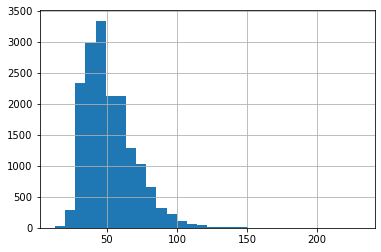

In [60]:
frame['total_area'].hist(bins = 30)



Здесь можно увидеть рапределение Пуассона, а так же заметить, что в основном площадь квартиры находится в области около 40-50 метров

Проанализируем значения 

In [61]:
list_of_columns_all = ['last_price','rooms',"ceiling_height",'first_day_exposition','days_exposition']

In [62]:
def frame_plot(frame,list_of_columns):
    for column in list_of_columns:
        frame[column].hist(bins = 15,figsize = (15,5))
        plt.title(column)
        plt.show()
        print()

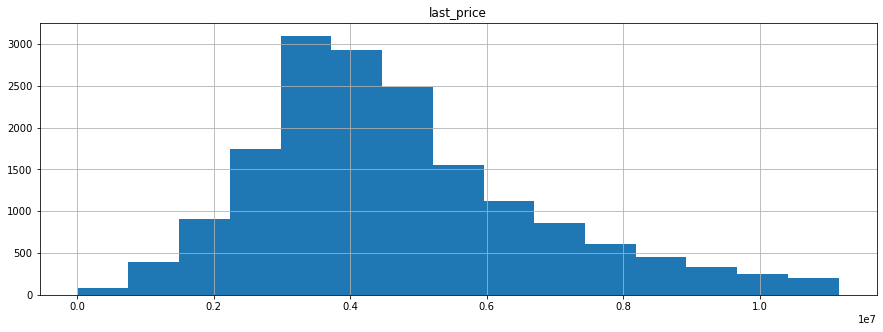

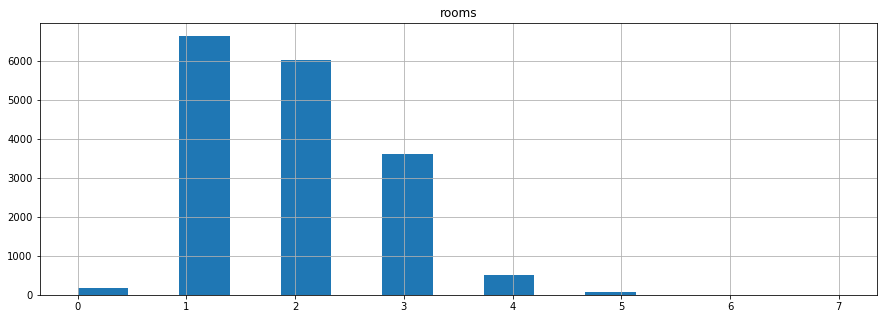

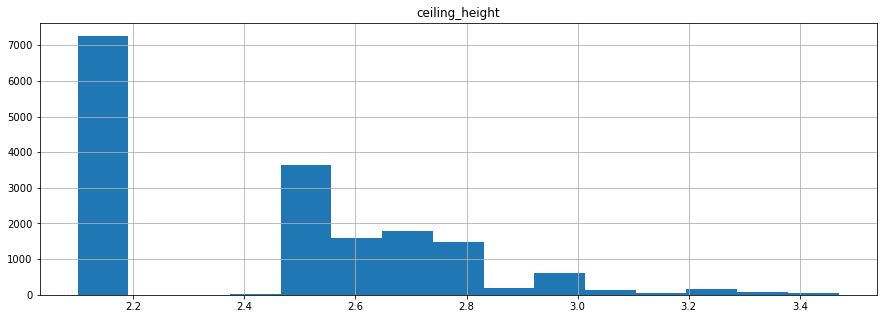

c:\users\anton\appdata\local\programs\python\python37-32\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


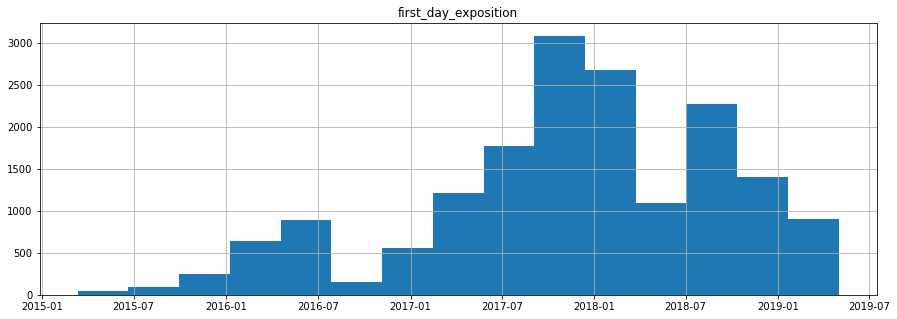

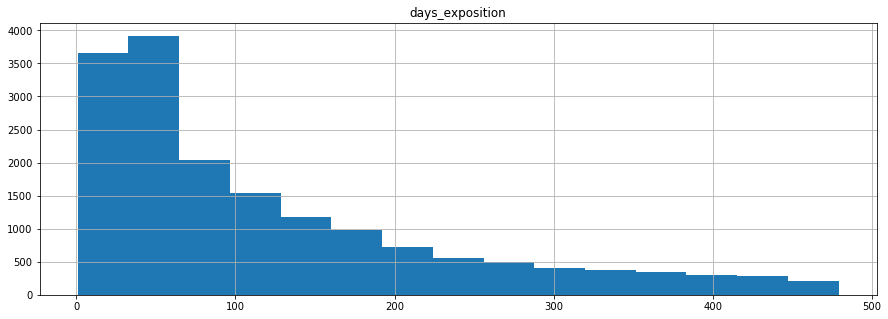

In [63]:
frame_plot(frame,list_of_columns_all)

<h3>Цена недвижимости:</h3> Здесь рапределение более похоже на нормальное
<h3>Количество комнат:</h3> Здесь мы можем увидеть, что основное окличество кварир являются 1-комнатными или 2-комнатными
<h3>Высота потолков:</h3> Основная масса квартир имеют потолки до 2.2, но так же встречаются и недвижимост с поталками больше 2.8 метров
<h3>День загрузки объявления:</h3> Здесь мы можем заметить, что основное количество объявлений появилось в течение полутора лет с осени 2017 по январь 2019
<h3>Длительность продажи:</h3> Здесь мы видем, что большая часть недвижимости продается в периоду между 15 - 100 днями с появления объявления на площадке. Но так же есть достаточно весомое количесвто обявлений, которое было в продаже больше года

Если посмотреть на медиану, то можно увидеть, что объявление закрывается за 79 дней

In [64]:
frame['days_exposition'].median()

79.0

В то время как среднее покажет нам гораздо более продолжительную продажу, целых ~ 120 дней. Это логично, так как в нашей выборке присутсвуют обявления которые продались, только через полтора года

In [65]:
frame['days_exposition'].mean()

121.22352111848676

In [66]:
frame['days_exposition'].describe()

count    17023.000
mean       121.224
std        113.803
min          1.000
25%         39.000
50%         79.000
75%        174.000
max        479.000
Name: days_exposition, dtype: float64

Если продажи прошли меньше чем за 39 дней, то можно сказать, что продажи прошли быстро, если это заняло больше 174 дней, то стоит обределить такой случай, как долгую продажу

Теперь изучим корреляцию цен от других параметров

                     total_area  rooms  cityCenters_nearest  last_price
total_area                1.000  0.803               -0.079       0.688
rooms                     0.803  1.000               -0.052       0.447
cityCenters_nearest      -0.079 -0.052                1.000      -0.206
last_price                0.688  0.447               -0.206       1.000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10E193D0>,
      dtype=object)

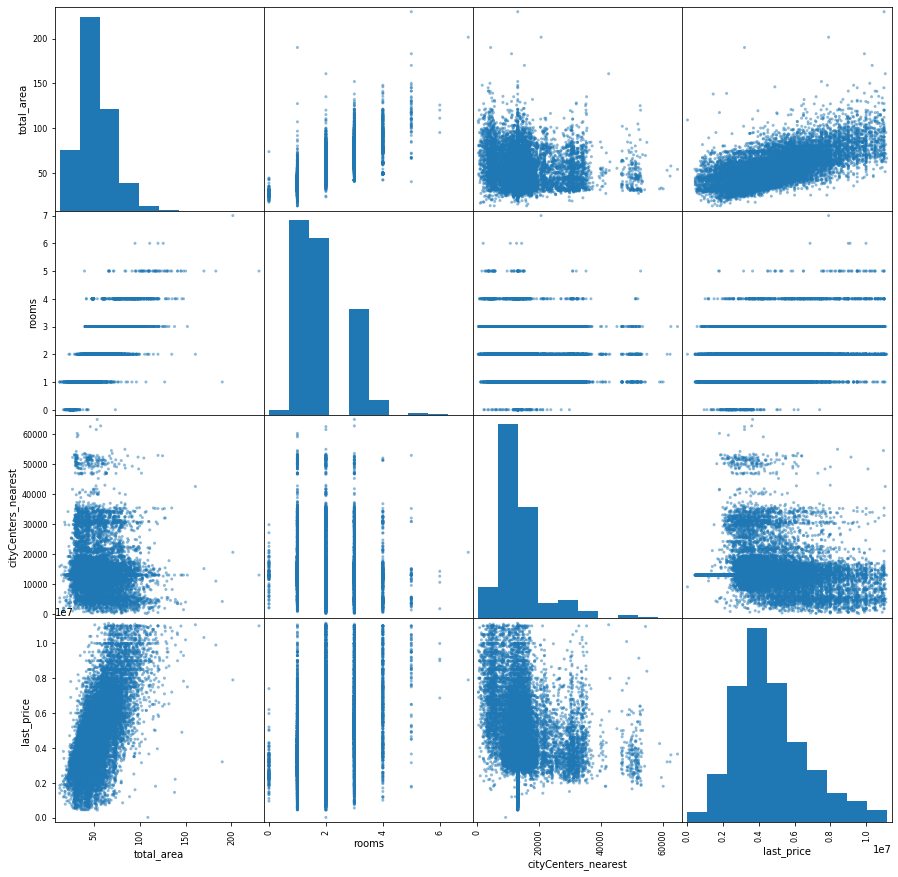

In [67]:
print(frame[["total_area","rooms","flat_category",'cityCenters_nearest','last_price']].corr())
pd.plotting.scatter_matrix(frame[["total_area","rooms","flat_category",'cityCenters_nearest','last_price']],figsize=(15,15))

Заметим, что цена больше зависит от общей площади, а не от количества комнат. Так же видно, что с ростом растояния до центра цена падает

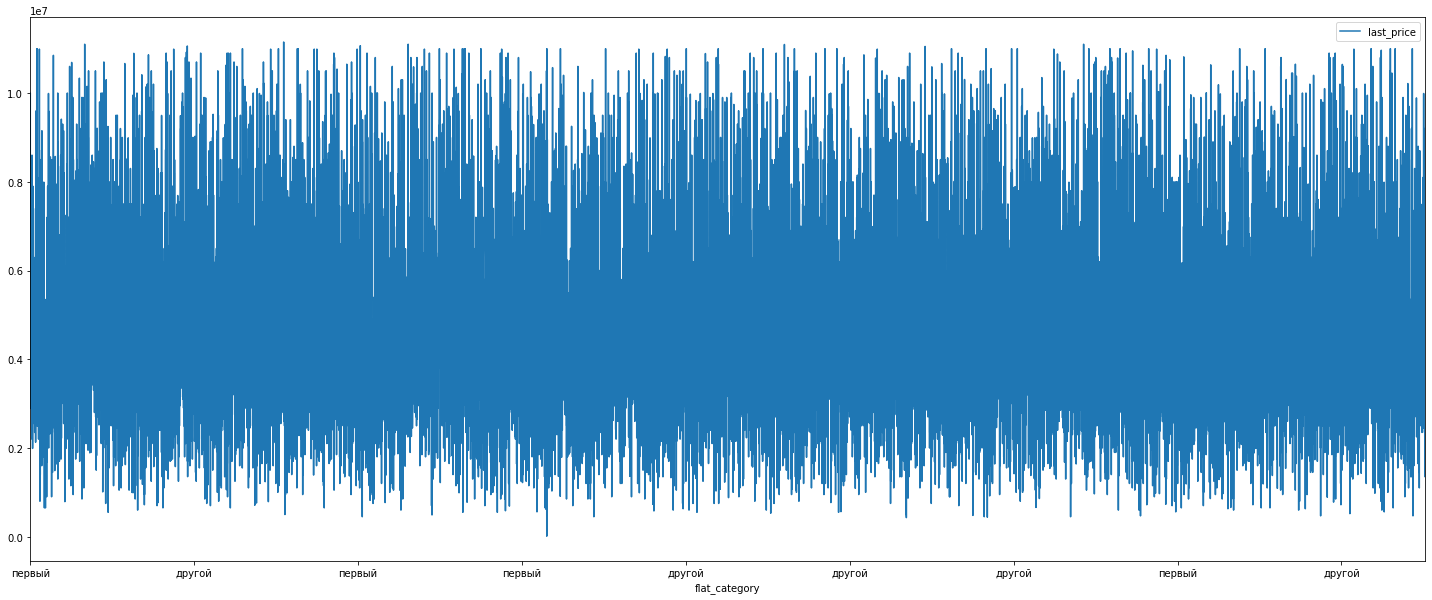

In [68]:
frame.plot(x = "flat_category", y = 'last_price', figsize = (25,10))

                  day_exposition  month_exposition  year_exposition  \
day_exposition             1.000            -0.008           -0.050   
month_exposition          -0.008             1.000           -0.230   
year_exposition           -0.050            -0.230            1.000   
last_price                 0.003             0.007            0.008   

                  last_price  
day_exposition         0.003  
month_exposition       0.007  
year_exposition        0.008  
last_price             1.000  


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0F279D70>,
      dtype=object)

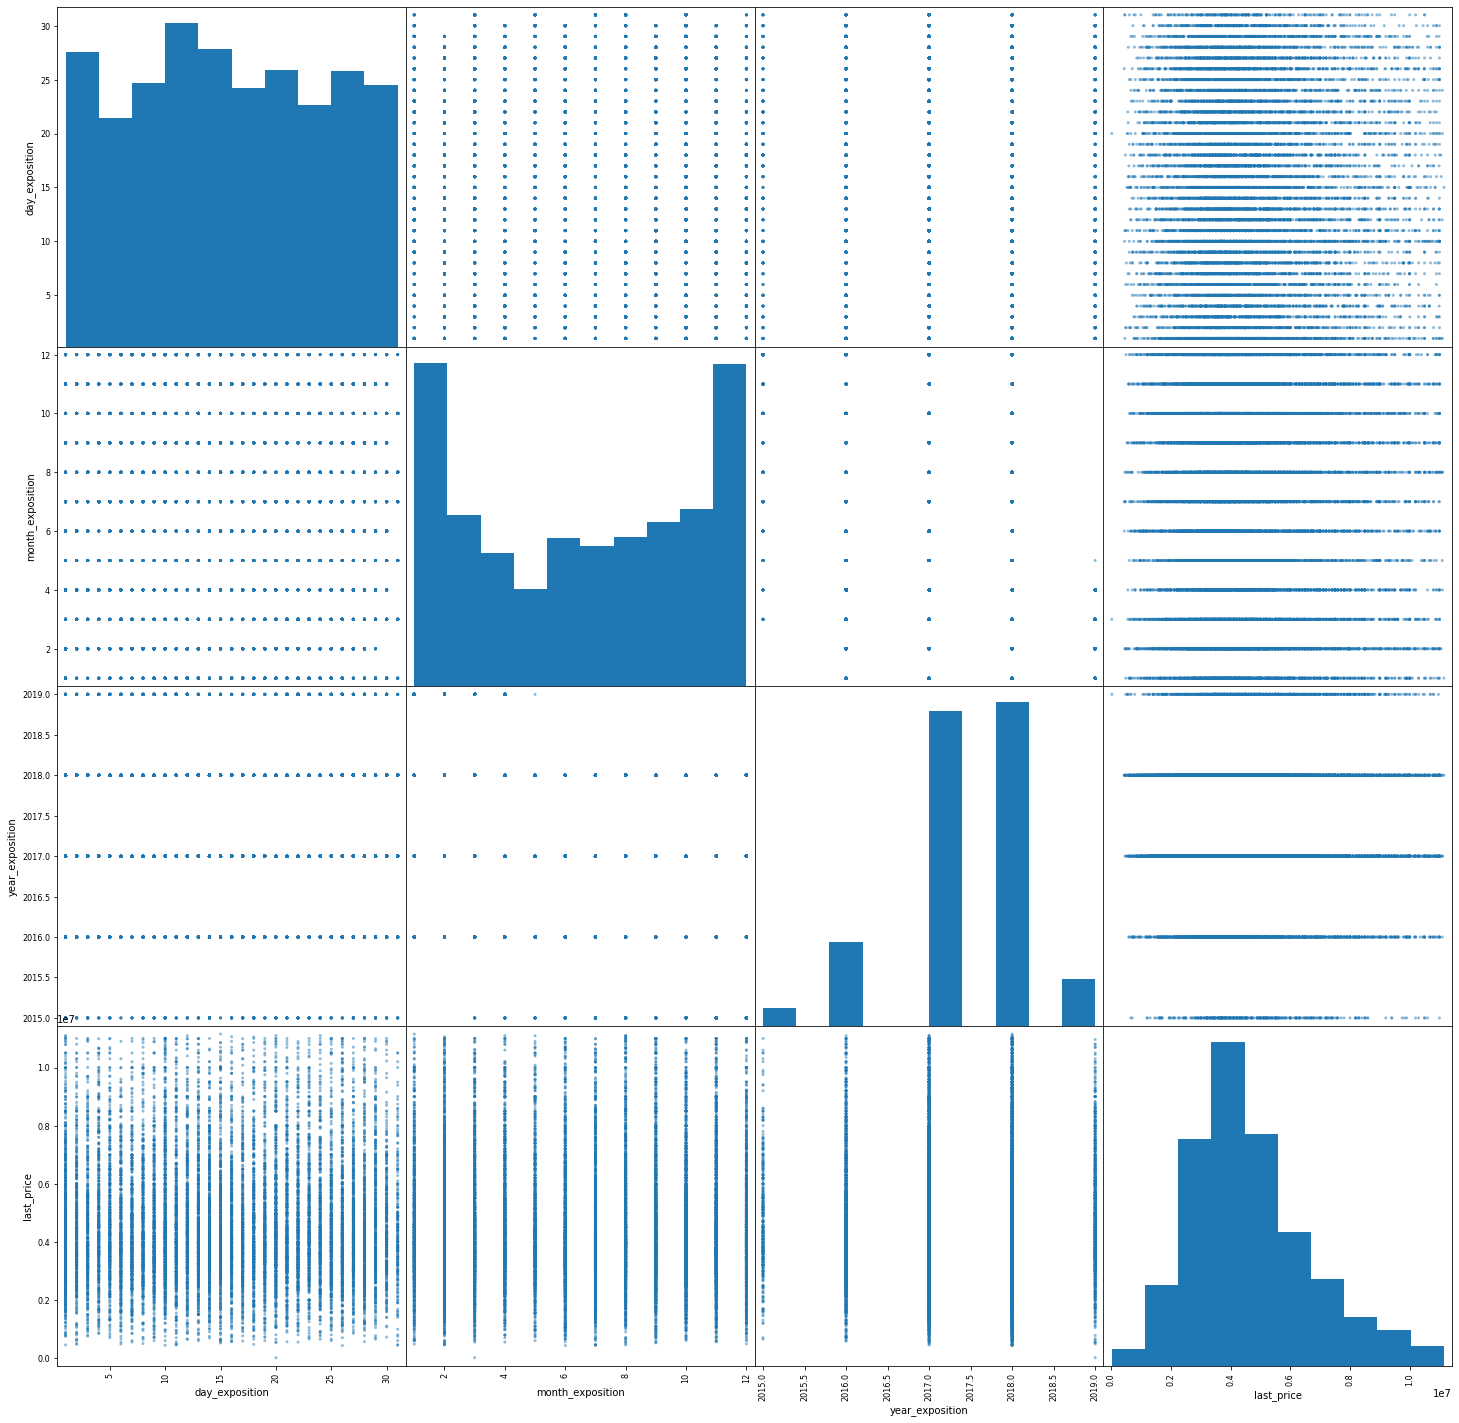

In [69]:
print(frame[['day_exposition','month_exposition','year_exposition','last_price']].corr())
pd.plotting.scatter_matrix(frame[['day_exposition','month_exposition','year_exposition','last_price']],figsize=(25,25))

Отсюда мы можем точно сказать, что цена не зависит от даты размещения

Сгруппируем по городу и посчитаем количество и среднее

In [70]:
locality_name_sorted_pivot_table = (frame
                                    .pivot_table(index = 'locality_name',
                                                     values = ["price_per_meter"],
                                                     aggfunc = ["count","mean"]))

In [71]:
locality_name_sorted_pivot_table.columns = ["count","mean"]

In [72]:
locality_name_sorted_pivot_table.sort_values(by = "count",inplace = True,ascending = False)

In [73]:
locality_name_sorted_pivot_table = locality_name_sorted_pivot_table[:10]

In [74]:
locality_name_sorted_pivot_table

,count,mean
locality_name,,
санкт-петербург,10821,103791.257
посёлок мурино,477,85720.206
посёлок шушары,383,77535.755
всеволожск,302,66590.625
колпино,289,74427.972
посёлок парголово,284,88708.622
деревня кудрово,264,92395.645
пушкин,254,99044.779
гатчина,241,68012.202


Самая высокая цена в санкт-петербург, а сама низкая выборг из топ 10 по количесвту объявлений 

Добавим столбец с растоянием до центра в км

In [75]:
frame['cityCenters_nearest_km'] = frame['cityCenters_nearest'].apply(lambda x: x // 1000).astype('int')

Выделим объявления относящиеся к Петербургу и получим среднюю цену в зависимости от отдаления от центра

In [76]:
only_St_Petersburg = frame.query('locality_name	== "санкт-петербург"')

In [77]:
cityCenters_nearest_km_pivot_table = only_St_Petersburg.pivot_table(index ='cityCenters_nearest_km',
                                                        values = 'last_price',aggfunc = 'mean')

In [78]:
cityCenters_nearest_km_pivot_table = cityCenters_nearest_km_pivot_table.astype('int')

In [79]:
cityCenters_nearest_km_pivot_table['km'] = cityCenters_nearest_km_pivot_table.index
cityCenters_nearest_km_pivot_table.reset_index(drop = True,inplace = True)

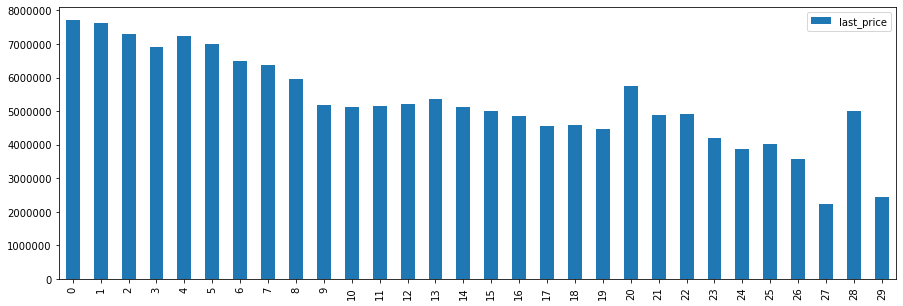

In [80]:
cityCenters_nearest_km_pivot_table.plot(y = "last_price",style = 'o',kind = 'bar',figsize = (15,5))

Четко виден перепад после 8 км, поэтому будем считать центром все что находитсяв радиусе 8 км

In [81]:
in_cityCenter =  frame.query('cityCenters_nearest_km < 9')


Построим графики и найдем корреляцию для недвижимости в центре Питера

                     rooms  floor  cityCenters_nearest  last_price
rooms                1.000 -0.170               -0.212       0.481
floor               -0.170  1.000                0.258       0.122
cityCenters_nearest -0.212  0.258                1.000      -0.233
last_price           0.481  0.122               -0.233       1.000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x112E9850>,
      dtype=object)

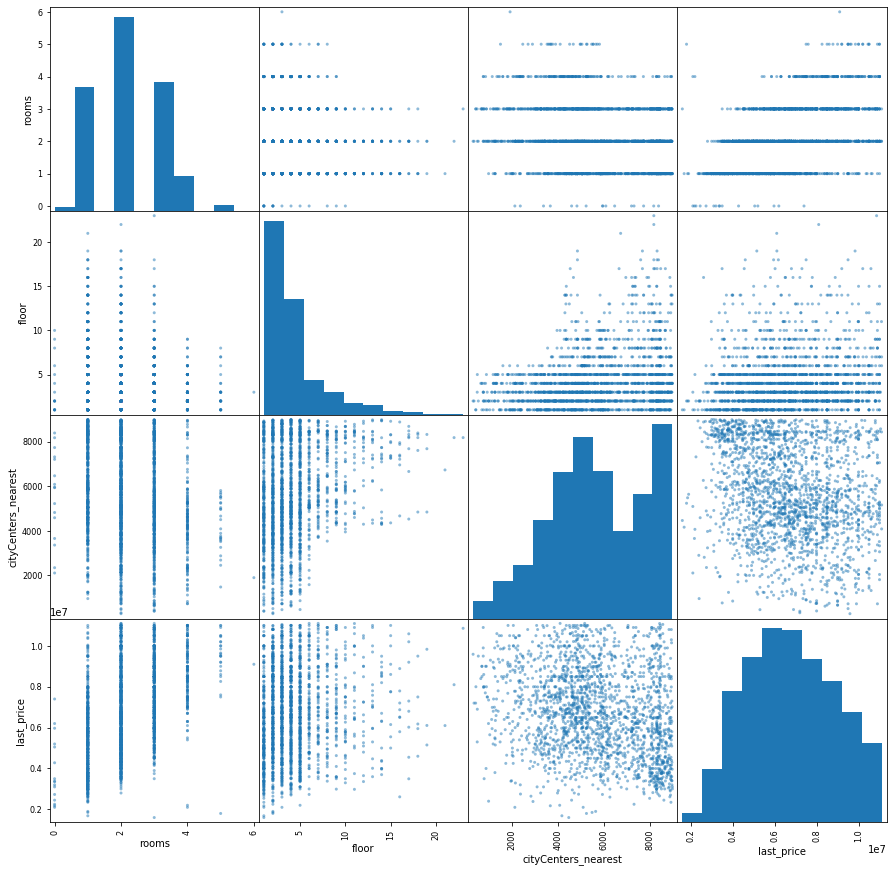

In [82]:
print(in_cityCenter[['rooms',
                                          'floor', 
                                          'cityCenters_nearest',
                                          'first_day_exposition',
                                          'last_price']].corr())

pd.plotting.scatter_matrix(in_cityCenter[['rooms',
                                          'floor', 
                                          'cityCenters_nearest',
                                          'first_day_exposition',
                                          'last_price']],figsize=(15,15))

Заметим, что цена зависит от отдаленности от центра, корелляция есть, но она небольшая. Так же цена сильно зависит от кличества комнат, можно сделать вывод, что в центре на цену больше влияет количество комнат

Посморим распределения по отдельным велечинам

In [83]:
list_of_columns_spb = ['last_price','rooms','total_area',"ceiling_height",'first_day_exposition']

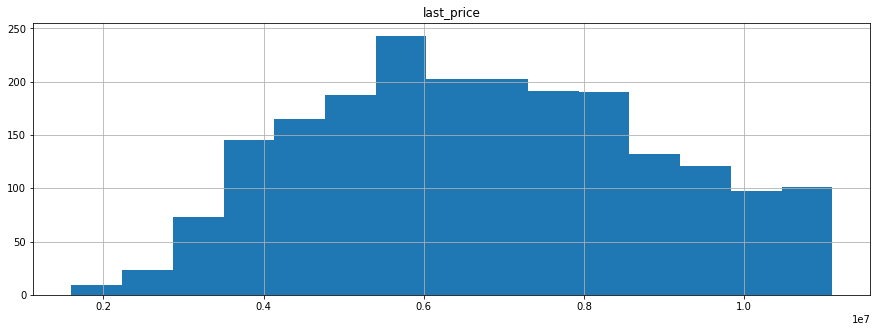

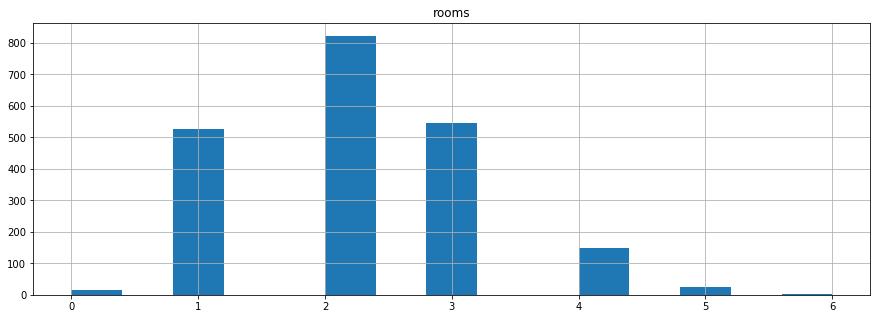

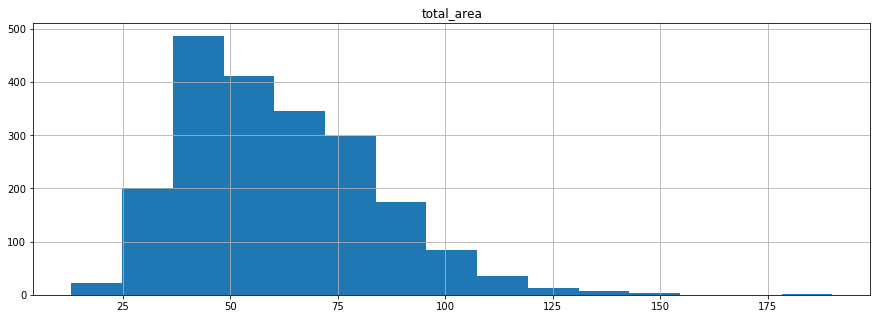

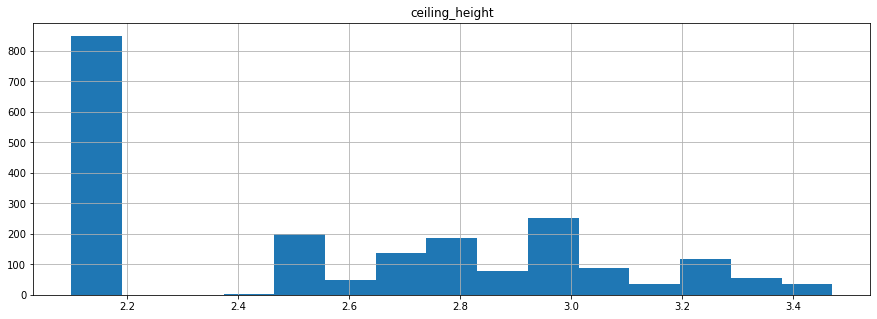

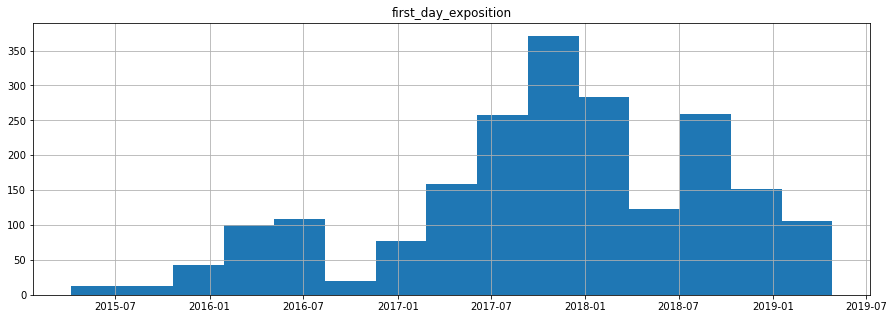

In [84]:
frame_plot(in_cityCenter,list_of_columns_spb)

<h3>Цена недвижимости:</h3>В отличии от всей выборки, здесь мы видем юольшой объем более дорогого жилья, которое хорошо видно по перевесу правой части графика
<h3>Количество комнат:</h3> относительно всех объявлений здесь виден количественный перевес 2-комнатных квартир 
<h3>Общая площадь:</h3> График сдвинулся в правую часть, что означает, что в центре преобладает жилье с площадью больше 50 метров
<h3>Высота потолков:</h3> На графике более выражены значения 3 метра и 3.2. Но все так же преобладают объекты с высотой потолков до 2.2 метром
<h3>День загрузки объявления:</h3> В питере основной период объявлений был короче и длился около года с осени 2017 года по осень 2018


### Шаг 5. Общий вывод

Предоставленные данные были достаточно грязными, но после очистки мы смогли их проанализировать и пришли к следующим выводам:
1. Цена звисит от общей площади и удаления от центра
1. В центре Питера общая площадь меньше влияет на цену, в отличии от количества комнат, которые выходят на первых план
1. Основной объем объявлений выл вывешен в период 2017 - 2019
1. Большее количество квартир имеют высоту потолку не превосходящую 2.2 метра
1. Чаще встречаются 1-комнатные и 2-комнатные квартиры
1. По большей части объекты продаются в течение 79-120 дней 